<a href="https://colab.research.google.com/github/jmoralespineda/TAM_TEORIA_APRENDIZAJE_DE_MAQUINA/blob/main/nfl_big_data_bowl_2026_analysis_prediction_467325.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2026-prediction/sample_submission.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w17.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w10.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w03.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w18.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w11.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w12.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w16.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w06.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w18.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
warnings.filterwarnings('ignore')

# ============================================================================
# GPU CONFIGURATION & OPTIMIZATION
# ============================================================================

def setup_gpu():
    """Configure GPU for optimal performance"""
    print("="*80)
    print("GPU CONFIGURATION")
    print("="*80)

    # Check available GPUs
    gpus = tf.config.list_physical_devices('GPU')
    print(f"\n🖥️  Available GPUs: {len(gpus)}")

    if gpus:
        try:
            # Enable memory growth (don't allocate all GPU memory at once)
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"   ✓ GPU: {gpu.name} - Memory growth enabled")

            # Set GPU memory limit (optional - useful if sharing GPU)
            # tf.config.set_logical_device_configuration(
            #     gpus[0],
            #     [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB
            # )

            # Use mixed precision for faster training
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print(f"   ✓ Mixed precision enabled: {policy.name}")

            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"   ✓ Logical GPUs: {len(logical_gpus)}")

        except RuntimeError as e:
            print(f"   ⚠️  GPU configuration error: {e}")
    else:
        print("   ⚠️  No GPU found - using CPU (training will be slower)")

    # Set TensorFlow options for better performance
    tf.config.optimizer.set_jit(True)  # XLA compilation
    print("   ✓ XLA (Accelerated Linear Algebra) enabled")

    print(f"\n📊 TensorFlow version: {tf.__version__}")
    print(f"📊 Keras version: {keras.__version__}")

    return len(gpus) > 0

# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    'sequence_length': 10,
    'max_frames_to_predict': 15,
    'batch_size': 256,  # Larger batch for GPU
    'epochs': 100,
    'learning_rate': 0.001,
    'validation_split': 0.15,
    'use_gpu': True,
}

# ============================================================================
# EVALUATION METRICS
# ============================================================================

def calculate_rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_mae(y_true, y_pred):
    """Calculate Mean Absolute Error"""
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def calculate_euclidean_distance(y_true, y_pred):
    """Calculate Euclidean distance between predicted and actual positions"""
    distances = np.sqrt((y_true[:, 0] - y_pred[:, 0])**2 +
                       (y_true[:, 1] - y_pred[:, 1])**2)
    return distances

def evaluate_predictions(y_true, y_pred, split_name="Validation"):
    """Comprehensive evaluation of predictions"""
    print("\n" + "="*80)
    print(f"📊 {split_name.upper()} SET EVALUATION")
    print("="*80)

    # Overall metrics
    x_rmse = calculate_rmse(y_true[:, 0], y_pred[:, 0])
    y_rmse = calculate_rmse(y_true[:, 1], y_pred[:, 1])

    x_mae = calculate_mae(y_true[:, 0], y_pred[:, 0])
    y_mae = calculate_mae(y_true[:, 1], y_pred[:, 1])

    # Euclidean distance
    distances = calculate_euclidean_distance(y_true, y_pred)
    mean_distance = np.mean(distances)
    median_distance = np.median(distances)

    print(f"\n🎯 POSITION ACCURACY:")
    print(f"   X-coordinate:")
    print(f"      RMSE: {x_rmse:.3f} yards")
    print(f"      MAE:  {x_mae:.3f} yards")

    print(f"\n   Y-coordinate:")
    print(f"      RMSE: {y_rmse:.3f} yards")
    print(f"      MAE:  {y_mae:.3f} yards")

    print(f"\n📏 EUCLIDEAN DISTANCE:")
    print(f"   Mean:   {mean_distance:.3f} yards")
    print(f"   Median: {median_distance:.3f} yards")
    print(f"   Std:    {np.std(distances):.3f} yards")
    print(f"   Min:    {np.min(distances):.3f} yards")
    print(f"   Max:    {np.max(distances):.3f} yards")

    # Percentiles
    print(f"\n📊 DISTANCE PERCENTILES:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"   {p}th percentile: {np.percentile(distances, p):.3f} yards")

    # Accuracy buckets
    print(f"\n🎯 ACCURACY BUCKETS:")
    for threshold in [1, 2, 5, 10, 15, 20]:
        within = (distances <= threshold).sum()
        pct = 100 * within / len(distances)
        print(f"   Within {threshold:2d} yards: {within:6,} ({pct:5.2f}%)")

    metrics = {
        'x_rmse': x_rmse,
        'y_rmse': y_rmse,
        'x_mae': x_mae,
        'y_mae': y_mae,
        'mean_distance': mean_distance,
        'median_distance': median_distance,
        'distances': distances
    }

    return metrics

def plot_predictions(y_true, y_pred, split_name="Validation", save_path="predictions_plot.png"):
    """Visualize predictions vs actual"""

    fig = plt.figure(figsize=(20, 12))

    # 1. X predictions scatter
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.3, s=1)
    ax1.plot([0, 120], [0, 120], 'r--', linewidth=2)
    ax1.set_xlabel('Actual X (yards)', fontsize=12)
    ax1.set_ylabel('Predicted X (yards)', fontsize=12)
    ax1.set_title(f'{split_name} - X Coordinate', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)

    # 2. Y predictions scatter
    ax2 = plt.subplot(2, 3, 2)
    ax2.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.3, s=1)
    ax2.plot([0, 53.3], [0, 53.3], 'r--', linewidth=2)
    ax2.set_xlabel('Actual Y (yards)', fontsize=12)
    ax2.set_ylabel('Predicted Y (yards)', fontsize=12)
    ax2.set_title(f'{split_name} - Y Coordinate', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)

    # 3. Error distribution
    ax3 = plt.subplot(2, 3, 3)
    distances = calculate_euclidean_distance(y_true, y_pred)
    ax3.hist(distances, bins=50, alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(distances), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(distances):.2f}')
    ax3.set_xlabel('Euclidean Distance Error (yards)', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)

    # 4. X error distribution
    ax4 = plt.subplot(2, 3, 4)
    x_errors = y_true[:, 0] - y_pred[:, 0]
    ax4.hist(x_errors, bins=50, alpha=0.7, edgecolor='black', color='green')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('X Error (yards)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title(f'X Error - Mean: {np.mean(x_errors):.3f}', fontsize=14, fontweight='bold')
    ax4.grid(alpha=0.3)

    # 5. Y error distribution
    ax5 = plt.subplot(2, 3, 5)
    y_errors = y_true[:, 1] - y_pred[:, 1]
    ax5.hist(y_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
    ax5.axvline(0, color='red', linestyle='--', linewidth=2)
    ax5.set_xlabel('Y Error (yards)', fontsize=12)
    ax5.set_ylabel('Frequency', fontsize=12)
    ax5.set_title(f'Y Error - Mean: {np.mean(y_errors):.3f}', fontsize=14, fontweight='bold')
    ax5.grid(alpha=0.3)

    # 6. Cumulative accuracy
    ax6 = plt.subplot(2, 3, 6)
    sorted_distances = np.sort(distances)
    cumulative = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances) * 100
    ax6.plot(sorted_distances, cumulative, linewidth=2)
    ax6.set_xlabel('Distance Threshold (yards)', fontsize=12)
    ax6.set_ylabel('Cumulative % of Predictions', fontsize=12)
    ax6.set_title('Cumulative Accuracy Curve', fontsize=14, fontweight='bold')
    ax6.grid(alpha=0.3)

    # Add benchmarks
    for threshold in [5, 10, 15]:
        pct = (distances <= threshold).sum() / len(distances) * 100
        ax6.axvline(threshold, linestyle='--', alpha=0.5)
        ax6.text(threshold, pct, f'{pct:.1f}%', fontsize=10)

    plt.suptitle(f'{split_name} Set - Prediction Analysis',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved plot: {save_path}")

    return fig

def plot_training_history(history, save_path="training_history.png"):
    """Plot training history"""

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # MAE plot
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE (yards)', fontsize=12)
    axes[1].set_title('Training and Validation MAE', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved plot: {save_path}")

    return fig

# ============================================================================
# IMPORT FUNCTIONS FROM ORIGINAL CODE
# ============================================================================

def parse_height(height_str):
    if pd.isna(height_str):
        return np.nan
    try:
        feet, inches = map(int, str(height_str).split('-'))
        return feet * 12 + inches
    except:
        return np.nan

def calculate_age(birth_date, reference_date='2023-09-01'):
    try:
        birth = pd.to_datetime(birth_date)
        ref = pd.to_datetime(reference_date)
        return (ref - birth).days / 365.25
    except:
        return np.nan

def load_training_data(data_path='/kaggle/input/nfl-big-data-bowl-2026-prediction/train'):
    print("\n" + "="*80)
    print("LOADING TRAINING DATA")
    print("="*80)

    all_data = []
    for week in range(1, 19):
        file_path = f'{data_path}/input_2023_w{week:02d}.csv'
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
            print(f"✓ Week {week:02d}: {len(df):,} rows | {df['play_id'].nunique():,} plays")
        except FileNotFoundError:
            print(f"✗ Week {week:02d}: File not found")

    train_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal training data: {len(train_df):,} rows")
    print(f" Unique plays: {(train_df['game_id'].astype(str) + '_' + train_df['play_id'].astype(str)).nunique():,}")
    print(f"Players to predict: {train_df['player_to_predict'].sum():,}")

    return train_df

def load_test_data():
    print("\n" + "="*80)
    print("LOADING TEST DATA")
    print("="*80)

    test_input = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv')
    test_targets = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv')

    print(f"✓ Test input: {len(test_input):,} rows")
    print(f"✓ Test targets: {len(test_targets):,} predictions needed")

    return test_input, test_targets

def normalize_play_direction(df):
    df = df.copy()
    left_mask = df['play_direction'] == 'left'
    num_flipped = left_mask.sum()

    df.loc[left_mask, 'x'] = 120 - df.loc[left_mask, 'x']
    df.loc[left_mask, 'y'] = 53.3 - df.loc[left_mask, 'y']
    df.loc[left_mask, 'dir'] = (df.loc[left_mask, 'dir'] + 180) % 360
    df.loc[left_mask, 'o'] = (df.loc[left_mask, 'o'] + 180) % 360

    if 'ball_land_x' in df.columns:
        df.loc[left_mask, 'ball_land_x'] = 120 - df.loc[left_mask, 'ball_land_x']
        df.loc[left_mask, 'ball_land_y'] = 53.3 - df.loc[left_mask, 'ball_land_y']

    print(f"   Normalized {num_flipped:,} plays moving left → right")
    return df

def engineer_features(df):
    print("\n" + "="*80)
    print("FEATURE ENGINEERING")
    print("="*80)

    df = df.copy()

    print("✓ Computing velocity components (vx, vy)")
    df['vx'] = df['s'] * np.cos(np.radians(df['dir']))
    df['vy'] = df['s'] * np.sin(np.radians(df['dir']))

    print("✓ Computing orientation components (ox, oy)")
    df['ox'] = np.cos(np.radians(df['o']))
    df['oy'] = np.sin(np.radians(df['o']))

    if 'ball_land_x' in df.columns:
        print("✓ Computing ball landing features")
        df['dist_to_ball'] = np.sqrt(
            (df['x'] - df['ball_land_x'])**2 +
            (df['y'] - df['ball_land_y'])**2
        )
        df['angle_to_ball'] = np.arctan2(
            df['ball_land_y'] - df['y'],
            df['ball_land_x'] - df['x']
        )
        df['vel_toward_ball'] = df['s'] * np.cos(np.radians(df['dir']) - df['angle_to_ball'])
    else:
        df['dist_to_ball'] = 0
        df['angle_to_ball'] = 0
        df['vel_toward_ball'] = 0

    print("✓ Computing field position features")
    df['dist_to_left_sideline'] = df['y']
    df['dist_to_right_sideline'] = 53.3 - df['y']
    df['dist_to_nearest_sideline'] = np.minimum(df['y'], 53.3 - df['y'])
    df['dist_to_endzone'] = 120 - df['x']

    print("✓ Processing player attributes")
    df['height_inches'] = df['player_height'].apply(parse_height)
    df['height_inches'] = df['height_inches'].fillna(df['height_inches'].median())

    df['player_age'] = df['player_birth_date'].apply(calculate_age)
    df['player_age'] = df['player_age'].fillna(df['player_age'].median())

    df['bmi'] = (df['player_weight'] * 703) / (df['height_inches'] ** 2)
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())

    print("✓ Creating temporal features (lags, differences)")
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])

    group_cols = ['game_id', 'play_id', 'nfl_id']
    for lag in [1, 2, 3]:
        for col in ['x', 'y', 's', 'a', 'vx', 'vy']:
            df[f'{col}_lag{lag}'] = df.groupby(group_cols)[col].shift(lag)

    df['speed_change'] = df.groupby(group_cols)['s'].diff()
    df['accel_change'] = df.groupby(group_cols)['a'].diff()
    df['dir_change'] = df.groupby(group_cols)['dir'].diff()

    df.loc[df['dir_change'] > 180, 'dir_change'] -= 360
    df.loc[df['dir_change'] < -180, 'dir_change'] += 360

    print("✓ Computing rolling statistics")
    for col in ['s', 'a']:
        df[f'{col}_roll_mean'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
        df[f'{col}_roll_std'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).std()
        )

    df = df.fillna(method='bfill').fillna(method='ffill').fillna(0)

    print(f"\n📊 Features created: {len(df.columns)} total columns")

    return df

def encode_categorical(df, encoders=None):
    df = df.copy()
    categorical_cols = ['player_position', 'player_side', 'player_role']

    if encoders is None:
        encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
        return df, encoders
    else:
        for col in categorical_cols:
            if col in encoders:
                df[col] = df[col].astype(str).map(
                    lambda x: x if x in encoders[col].classes_ else encoders[col].classes_[0]
                )
                df[col] = encoders[col].transform(df[col])
        return df

def create_sequences(df, sequence_length=10, for_training=True):
    print("\n" + "="*80)
    print("CREATING SEQUENCES")
    print("="*80)

    sequence_features = [
        'x', 'y', 's', 'a', 'vx', 'vy', 'ox', 'oy', 'dir', 'o',
        'x_lag1', 'y_lag1', 's_lag1', 'a_lag1',
        'x_lag2', 'y_lag2', 's_lag2', 'a_lag2',
        'x_lag3', 'y_lag3', 's_lag3', 'a_lag3',
        'speed_change', 'accel_change', 'dir_change',
        's_roll_mean', 'a_roll_mean',
        'dist_to_left_sideline', 'dist_to_right_sideline', 'dist_to_nearest_sideline'
    ]

    static_features = [
        'player_position', 'player_side', 'player_role',
        'height_inches', 'player_weight', 'player_age', 'bmi',
        'absolute_yardline_number', 'dist_to_ball', 'angle_to_ball'
    ]

    sequences = []
    static_data = []
    targets = []
    metadata = []

    grouped = df.groupby(['game_id', 'play_id', 'nfl_id'])

    for (game_id, play_id, nfl_id), group in grouped:
        if for_training and not group['player_to_predict'].any():
            continue

        group = group.sort_values('frame_id')

        if len(group) < sequence_length:
            continue

        seq_data = group[sequence_features].iloc[-sequence_length:].values
        static = group[static_features].iloc[-1].values

        sequences.append(seq_data)
        static_data.append(static)

        if for_training and 'ball_land_x' in group.columns:
            target_x = group['ball_land_x'].iloc[-1]
            target_y = group['ball_land_y'].iloc[-1]
            targets.append([target_x, target_y])

        metadata.append({
            'game_id': game_id,
            'play_id': play_id,
            'nfl_id': nfl_id,
            'num_frames_output': group['num_frames_output'].iloc[-1] if 'num_frames_output' in group.columns else 0,
            'last_x': group['x'].iloc[-1],
            'last_y': group['y'].iloc[-1],
        })

    sequences = np.array(sequences, dtype=np.float32)
    static_data = np.array(static_data, dtype=np.float32)

    if for_training and len(targets) > 0:
        targets = np.array(targets, dtype=np.float32)
    else:
        targets = None

    print(f"✓ Created {len(sequences):,} sequences")
    print(f"✓ Sequence shape: {sequences.shape}")
    print(f"✓ Static shape: {static_data.shape}")
    if targets is not None:
        print(f"✓ Target shape: {targets.shape}")

    return sequences, static_data, targets, metadata

def build_model(sequence_shape, static_shape):
    print("\n" + "="*80)
    print("BUILDING MODEL")
    print("="*80)

    sequence_input = layers.Input(shape=sequence_shape, name='sequence_input')

    x = layers.LSTM(128, return_sequences=True)(sequence_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    static_input = layers.Input(shape=(static_shape,), name='static_input')
    s = layers.Dense(64, activation='relu')(static_input)
    s = layers.BatchNormalization()(s)
    s = layers.Dropout(0.2)(s)
    s = layers.Dense(32, activation='relu')(s)

    combined = layers.concatenate([x, s])

    z = layers.Dense(128, activation='relu')(combined)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.3)(z)

    z = layers.Dense(64, activation='relu')(z)
    z = layers.Dropout(0.2)(z)

    # For mixed precision, use float32 output
    output = layers.Dense(2, dtype='float32', name='position_output')(z)

    model = keras.Model(
        inputs=[sequence_input, static_input],
        outputs=output
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae', 'mse']
    )

    model.summary()

    return model

def train_model(model, X_seq, X_static, y, validation_split=0.15):
    print("\n" + "="*80)
    print("TRAINING MODEL")
    print("="*80)

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    history = model.fit(
        [X_seq, X_static], y,
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def create_submission(model, test_input, test_targets, metadata_lookup, scalers):
    print("\n" + "="*80)
    print("GENERATING PREDICTIONS")
    print("="*80)

    pred_dict = {}
    for meta, pred in zip(metadata_lookup, model.predict([test_input[0], test_input[1]], verbose=1)):
        key = (meta['game_id'], meta['play_id'], meta['nfl_id'])
        pred_dict[key] = {
            'x': pred[0],
            'y': pred[1],
            'last_x': meta['last_x'],
            'last_y': meta['last_y']
        }

    submissions = []
    for _, row in test_targets.iterrows():
        key = (row['game_id'], row['play_id'], row['nfl_id'])

        if key in pred_dict:
            x_pred = pred_dict[key]['x']
            y_pred = pred_dict[key]['y']
        else:
            x_pred = 60.0
            y_pred = 26.65

        submissions.append({
            'id': f"{row['game_id']}_{row['play_id']}_{row['nfl_id']}_{row['frame_id']}",
            'x': x_pred,
            'y': y_pred
        })

    submission_df = pd.DataFrame(submissions)
    submission_df.to_csv('submission.csv', index=False)

    print(f"✓ Submission created: {len(submission_df):,} predictions")
    print(f"✓ Saved to: submission.csv")

    return submission_df

# ============================================================================
# MAIN PIPELINE WITH EVALUATION
# ============================================================================


'''
def main():
    start_time = datetime.now()

    print("\n" + "="*80)
    print(" NFL BIG DATA BOWL 2026 - ENHANCED PIPELINE WITH EVALUATION")
    print("="*80)

    # Setup GPU
    has_gpu = setup_gpu()

    # Load data
    train_df = load_training_data()
    test_input_df, test_targets_df = load_test_data()

    # Preprocess
    print("\n📍 Step 1: Normalizing play direction...")
    train_df = normalize_play_direction(train_df)
    test_input_df = normalize_play_direction(test_input_df)

    # Feature engineering
    print("\n📍 Step 2: Feature engineering...")
    train_df = engineer_features(train_df)
    test_input_df = engineer_features(test_input_df)

    # Encode categorical
    print("\n📍 Step 3: Encoding categorical variables...")
    train_df, encoders = encode_categorical(train_df)
    test_input_df = encode_categorical(test_input_df, encoders)

    # Create sequences
    print("\n📍 Step 4: Creating sequences...")
    X_seq_all, X_static_all, y_all, metadata_all = create_sequences(
        train_df, CONFIG['sequence_length'], for_training=True
    )

    X_seq_test, X_static_test, _, metadata_test = create_sequences(
        test_input_df, CONFIG['sequence_length'], for_training=False
    )

    # Split train/validation
    print("\n📍 Step 5: Splitting train/validation...")
    n_samples = len(X_seq_all)
    n_val = int(n_samples * CONFIG['validation_split'])

    # Random shuffle
    indices = np.random.permutation(n_samples)
    train_idx = indices[n_val:]
    val_idx = indices[:n_val]

    X_seq_train = X_seq_all[train_idx]
    X_static_train = X_static_all[train_idx]
    y_train = y_all[train_idx]

    X_seq_val = X_seq_all[val_idx]
    X_static_val = X_static_all[val_idx]
    y_val = y_all[val_idx]

    print(f"   Training samples: {len(X_seq_train):,}")
    print(f"   Validation samples: {len(X_seq_val):,}")

    # Scale features
    print("\n📍 Step 6: Scaling features...")
    scaler_seq = StandardScaler()
    scaler_static = StandardScaler()

    # Scale sequence features
    X_seq_train_flat = X_seq_train.reshape(-1, X_seq_train.shape[-1])
    X_seq_train_scaled = scaler_seq.fit_transform(X_seq_train_flat).reshape(X_seq_train.shape)

    X_seq_val_flat = X_seq_val.reshape(-1, X_seq_val.shape[-1])
    X_seq_val_scaled = scaler_seq.transform(X_seq_val_flat).reshape(X_seq_val.shape)

    # Scale static features
    X_static_train_scaled = scaler_static.fit_transform(X_static_train)
    X_static_val_scaled = scaler_static.transform(X_static_val)

    # Scale test features
    X_seq_test_flat = X_seq_test.reshape(-1, X_seq_test.shape[-1])
    X_seq_test_scaled = scaler_seq.transform(X_seq_test_flat).reshape(X_seq_test.shape)
    X_static_test_scaled = scaler_static.transform(X_static_test)

    # Build model
    print("\n📍 Step 7: Building model...")
    model = build_model(
        sequence_shape=(X_seq_train.shape[1], X_seq_train.shape[2]),
        static_shape=X_static_train.shape[1]
    )

    # Train model WITHOUT validation_split (we already split)
    print("\n📍 Step 8: Training model...")

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    history = model.fit(
        [X_seq_train_scaled, X_static_train_scaled], y_train,
        validation_data=([X_seq_val_scaled, X_static_val_scaled], y_val),
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    print("\n📍 Step 9: Plotting training history...")
    plot_training_history(history, "training_history.png")

    # Evaluate on training set
    print("\n📍 Step 10: Evaluating on training set...")
    y_train_pred = model.predict([X_seq_train_scaled, X_static_train_scaled], verbose=0)
    train_metrics = evaluate_predictions(y_train, y_train_pred, "Training")
    plot_predictions(y_train, y_train_pred, "Training", "predictions_train.png")

    # Evaluate on validation set
    print("\n📍 Step 11: Evaluating on validation set...")
    y_val_pred = model.predict([X_seq_val_scaled, X_static_val_scaled], verbose=0)
    val_metrics = evaluate_predictions(y_val, y_val_pred, "Validation")
    plot_predictions(y_val, y_val_pred, "Validation", "predictions_val.png")

    # Save model and artifacts
    print("\n📍 Step 12: Saving model and artifacts...")
    model.save('nfl_model_final.keras')
    with open('scalers.pkl', 'wb') as f:
        pickle.dump({'seq': scaler_seq, 'static': scaler_static, 'encoders': encoders}, f)

    # Save metrics to file
    metrics_summary = {
        'training': {
            'x_rmse': float(train_metrics['x_rmse']),
            'y_rmse': float(train_metrics['y_rmse']),
            'x_mae': float(train_metrics['x_mae']),
            'y_mae': float(train_metrics['y_mae']),
            'mean_distance': float(train_metrics['mean_distance']),
            'median_distance': float(train_metrics['median_distance'])
        },
        'validation': {
            'x_rmse': float(val_metrics['x_rmse']),
            'y_rmse': float(val_metrics['y_rmse']),
            'x_mae': float(val_metrics['x_mae']),
            'y_mae': float(val_metrics['y_mae']),
            'mean_distance': float(val_metrics['mean_distance']),
            'median_distance': float(val_metrics['median_distance'])
        }
    }

    with open('metrics.pkl', 'wb') as f:
        pickle.dump(metrics_summary, f)

    # Create submission
    print("\n📍 Step 13: Creating submission...")
    submission = create_submission(
        model,
        (X_seq_test_scaled, X_static_test_scaled),
        test_targets_df,
        metadata_test,
        {'seq': scaler_seq, 'static': scaler_static}
    )

    # Final summary
    end_time = datetime.now()
    duration = end_time - start_time

    print("\n" + "="*80)
    print("✅ PIPELINE COMPLETE!")
    print("="*80)

    print(f"\n⏱️  Total Time: {duration}")

    print(f"\n📁 Files created:")
    print(f"   • nfl_model_final.keras - Trained model")
    print(f"   • best_model.keras - Best model checkpoint")
    print(f"   • scalers.pkl - Feature scalers and encoders")
    print(f"   • metrics.pkl - Evaluation metrics")
    print(f"   • submission.csv - Final predictions ({len(submission):,} rows)")
    print(f"   • training_history.png - Training curves")
    print(f"   • predictions_train.png - Training set predictions")
    print(f"   • predictions_val.png - Validation set predictions")

    print(f"\n📊 FINAL RESULTS:")
    print(f"\n   Training Set:")
    print(f"      RMSE (X): {train_metrics['x_rmse']:.3f} yards")
    print(f"      RMSE (Y): {train_metrics['y_rmse']:.3f} yards")
    print(f"      Mean Distance Error: {train_metrics['mean_distance']:.3f} yards")

    print(f"\n   Validation Set:")
    print(f"      RMSE (X): {val_metrics['x_rmse']:.3f} yards")
    print(f"      RMSE (Y): {val_metrics['y_rmse']:.3f} yards")
    print(f"      Mean Distance Error: {val_metrics['mean_distance']:.3f} yards")

    print(f"\n🎯 Model Performance Summary:")
    within_5_val = (val_metrics['distances'] <= 5).sum() / len(val_metrics['distances']) * 100
    within_10_val = (val_metrics['distances'] <= 10).sum() / len(val_metrics['distances']) * 100
    print(f"   Predictions within 5 yards: {within_5_val:.1f}%")
    print(f"   Predictions within 10 yards: {within_10_val:.1f}%")

    print("\n" + "="*80)

    return model, history, submission, train_metrics, val_metrics

# ============================================================================
# RUN
# ============================================================================

if __name__ == "__main__":
    model, history, submission, train_metrics, val_metrics = main()
    '''

2025-10-13 16:02:25.029034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760371345.274044      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760371345.343499      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'\ndef main():\n    start_time = datetime.now()\n    \n    print("\n" + "="*80)\n    print(" NFL BIG DATA BOWL 2026 - ENHANCED PIPELINE WITH EVALUATION")\n    print("="*80)\n    \n    # Setup GPU\n    has_gpu = setup_gpu()\n    \n    # Load data\n    train_df = load_training_data()\n    test_input_df, test_targets_df = load_test_data()\n    \n    # Preprocess\n    print("\n📍 Step 1: Normalizing play direction...")\n    train_df = normalize_play_direction(train_df)\n    test_input_df = normalize_play_direction(test_input_df)\n    \n    # Feature engineering\n    print("\n📍 Step 2: Feature engineering...")\n    train_df = engineer_features(train_df)\n    test_input_df = engineer_features(test_input_df)\n    \n    # Encode categorical\n    print("\n📍 Step 3: Encoding categorical variables...")\n    train_df, encoders = encode_categorical(train_df)\n    test_input_df = encode_categorical(test_input_df, encoders)\n    \n    # Create sequences\n    print("\n📍 Step 4: Creating sequences...")\

# Inicio del punto 4

In [ ]:
#Verificacion de que GPU esté disponible:
!nvidia-smi



Mon Oct 13 16:49:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P0             32W /   70W |     153MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#Vericar versión de python
import sys
print(sys.version)


3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [ ]:
# Verficación de que RAPIDS esta disponible
import cudf, cupy, cuml

print("✅ RAPIDS está disponible en GPU")

# Validación simple
gdf = cudf.DataFrame({'x': cupy.arange(5), 'y': cupy.arange(5, 10)})
print(gdf)



✅ RAPIDS está disponible en GPU
   x  y
0  0  5
1  1  6
2  2  7
3  3  8
4  4  9


In [ ]:
#Activar Rapids
import cudf, cupy as cp, cuml

print("✅ RAPIDS activo en GPU Tesla T4")

# Crear DataFrame en GPU
df = cudf.DataFrame({
    'x': cp.arange(10),
    'y': cp.arange(10, 20)
})
print("\nDataFrame cuDF:\n", df)

# Operación de correlación en GPU
corr = df['x'].corr(df['y'])
print("\n🔹 Correlación (GPU):", corr)

# Usar cuML (modelo lineal GPU)
from cuml.linear_model import LinearRegression
model = LinearRegression()
model.fit(df[['x']], df['y'])
print("\n📈 Pendiente GPU:", float(model.coef_[0]))


✅ RAPIDS activo en GPU Tesla T4

DataFrame cuDF:
    x   y
0  0  10
1  1  11
2  2  12
3  3  13
4  4  14
5  5  15
6  6  16
7  7  17
8  8  18
9  9  19

🔹 Correlación (GPU): 0.9999999999999999

📈 Pendiente GPU: 1.0000001192092896


In [ ]:
# Verificar entorno RAPIDS
import cudf, cupy as cp, cuml
print("✅ RAPIDS listo y GPU activa")

# Prueba básica en GPU
gdf = cudf.DataFrame({'x': cp.arange(10), 'y': cp.arange(10, 20)})
print(gdf.head())

# Validar cálculo GPU
print("🔹 Correlación (GPU):", gdf['x'].corr(gdf['y']))


✅ RAPIDS listo y GPU activa
   x   y
0  0  10
1  1  11
2  2  12
3  3  13
4  4  14
🔹 Correlación (GPU): 0.9999999999999999


In [ ]:
# Cargar y explorar los datos del reto
import glob, os

base_path = '/kaggle/input/nfl-big-data-bowl-2026-prediction/train/'
input_files = sorted(glob.glob(os.path.join(base_path, 'input_2023_w*.csv')))
output_files = sorted(glob.glob(os.path.join(base_path, 'output_2023_w*.csv')))

# Cargar en GPU con cuDF
all_input = cudf.concat([cudf.read_csv(f) for f in input_files])
all_output = cudf.concat([cudf.read_csv(f) for f in output_files])

print("Input shape:", all_input.shape)
print("Output shape:", all_output.shape)


Input shape: (4880579, 23)
Output shape: (562936, 6)


In [ ]:
# Realizar el análisis exploratorio (EDA)
print("\n📊 Columnas del input:")
print(all_input.columns)

print("\n📈 Estadísticas generales:")
print(all_input.describe())

# Verificar valores nulos
print("\n🕳️ Valores faltantes por columna:")
print(all_input.isnull().sum())


📊 Columnas del input:
Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y'],
      dtype='object')

📈 Estadísticas generales:
            game_id       play_id        nfl_id      frame_id  \
count  4.880579e+06  4.880579e+06  4.880579e+06  4.880579e+06   
mean   2.023155e+09  2.196409e+03  4.955890e+04  1.613179e+01   
std    2.011405e+05  1.246426e+03  5.210338e+03  1.113008e+01   
min    2.023091e+09  5.400000e+01  3.084200e+04  1.000000e+00   
25%    2.023101e+09  1.150000e+03  4.519800e+04  8.000000e+00   
50%    2.023111e+09  2.171000e+03  5.241300e+04  1.500000e+01   
75%    2.023121e+09  3.246000e+03  5.450000e+04  2.200000e+01   
max    2.024011e+09  5.258000e+03  5.667300e+04  1.230000e+

**Importaciones y detección de RAPIDS (línea por línea)**

In [ ]:
# importar módulos del sistema y utilitarios
import os                                          # manejo de rutas
import glob                                        # búsqueda de archivos
import random                                      # para seeds reproducibles
import warnings                                    # silenciador de warnings
warnings.filterwarnings('ignore')                  # ocultar warnings no críticos

# Métricas y herramientas
import numpy as np                                 # numpy para operaciones numéricas (fallback)
import pandas as pd                                # pandas para manipulación tabular (fallback)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # métricas
def mape(y_true, y_pred):                          # función MAPE (evita división por cero)
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    mask = np.abs(y_true) > 1e-8
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Optimización bayesiana
import optuna                                       # Optuna para Bayesian optimization

# Modelos CPU (fallback)
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb                               # XGBoost (soporta GPU con tree_method=gpu_hist)

# Detectar RAPIDS (cudf/cuml) — usa si está disponible
USE_RAPIDS = False
try:
    import cudf                                     # si esto funciona, tenemos RAPIDS
    import cupy as cp
    from cuml.ensemble import RandomForestRegressor as cuRF
    from cuml.linear_model import LinearRegression as cuLinear
    from cuml.linear_model import Ridge as cuRidge
    from cuml.linear_model import ElasticNet as cuElasticNet
    USE_RAPIDS = True
    print("✅ RAPIDS detectado: usaremos cuDF/cuML")
except Exception as e:
    print("⚠️ RAPIDS no disponible o no cargado; usaremos pandas/scikit-learn. Error:", str(e))


✅ RAPIDS detectado: usaremos cuDF/cuML


In [ ]:
# Ruta base, ajústada si corresponde
BASE_PATH = '/kaggle/input/nfl-big-data-bowl-2026-prediction/train/'

# buscar los archivos input & output por semana
input_files = sorted(glob.glob(os.path.join(BASE_PATH, 'input_2023_w*.csv')))
output_files = sorted(glob.glob(os.path.join(BASE_PATH, 'output_2023_w*.csv')))

# función que carga y concatena, usando cudf si está disponible
def load_all(files, use_rapids=USE_RAPIDS):
    """Carga una lista de CSV y concatena en un DataFrame (cuDF o pandas)"""
    frames = []
    for f in files:
        if use_rapids:
            frames.append(cudf.read_csv(f))          # lectura en GPU
        else:
            frames.append(pd.read_csv(f))            # lectura en CPU
    if use_rapids:
        return cudf.concat(frames, ignore_index=True)
    else:
        return pd.concat(frames, ignore_index=True)

# cargar datasets
all_input = load_all(input_files)
all_output = load_all(output_files)

# mostrar shapes
print("Input shape:", (len(all_input), len(all_input.columns)))
print("Output shape:", (len(all_output), len(all_output.columns)))


Input shape: (4880579, 23)
Output shape: (562936, 6)


In [ ]:
# NORMALIZAR dirección de la jugada: left -> flip coordinates (hacerlo para todo)
def normalize_play_direction(df):
    # df puede ser cudf.DataFrame o pandas.DataFrame
    left_mask = df['play_direction'] == 'left'
    if USE_RAPIDS:
        # Para cudf, operaciones vectorizadas estilo pandas
        df.loc[left_mask, 'x'] = 120 - df.loc[left_mask, 'x']
        df.loc[left_mask, 'y'] = 53.3 - df.loc[left_mask, 'y']
        df.loc[left_mask, 'dir'] = (df.loc[left_mask, 'dir'] + 180) % 360
        df.loc[left_mask, 'o'] = (df.loc[left_mask, 'o'] + 180) % 360
    else:
        df.loc[left_mask, 'x'] = 120 - df.loc[left_mask, 'x']
        df.loc[left_mask, 'y'] = 53.3 - df.loc[left_mask, 'y']
        df.loc[left_mask, 'dir'] = (df.loc[left_mask, 'dir'] + 180) % 360
        df.loc[left_mask, 'o'] = (df.loc[left_mask, 'o'] + 180) % 360
    return df

# Feature engineering vectorizado
def engineer_features(df):
    """Crear features: vx, vy, ox, oy, dist_to_endzone, flight_time_sec y lag features si es necesario."""
    # velocidad componentes (vx, vy)
    if USE_RAPIDS:
        df['vx'] = df['s'] * cp.cos(cp.deg2rad(df['dir']))   # cupy trig en GPU
        df['vy'] = df['s'] * cp.sin(cp.deg2rad(df['dir']))
        df['ox'] = cp.cos(cp.deg2rad(df['o']))
        df['oy'] = cp.sin(cp.deg2rad(df['o']))
        df['dist_to_endzone'] = 120 - df['x']
        df['flight_time_sec'] = df['num_frames_output'] / 10.0
    else:
        df['vx'] = df['s'] * np.cos(np.deg2rad(df['dir']))
        df['vy'] = df['s'] * np.sin(np.deg2rad(df['dir']))
        df['ox'] = np.cos(np.deg2rad(df['o']))
        df['oy'] = np.sin(np.deg2rad(df['o']))
        df['dist_to_endzone'] = 120 - df['x']
        df['flight_time_sec'] = df['num_frames_output'] / 10.0

    # Imputaciones sencillas: alturas/peso/edad si existen
    if 'player_height' in df.columns:
        # parse height string like "6-2" to inches if needed -> aquí asumimos ya numérico; si str conviene parsear
        pass

    return df

# aplicar normalización y features
all_input = normalize_play_direction(all_input)
all_input = engineer_features(all_input)

# para outputs, no necesitamos normalizar direccionalidad (son posiciones finales)


In [ ]:
# Crear una fila por jugador/play que represente la última observación antes del pase
# y el target será la coordenada (ball_land_x, ball_land_y) en output para ese jugador.

# Primero, obtener la última fila de input por (game_id, play_id, nfl_id)
group_cols = ['game_id', 'play_id', 'nfl_id']

if USE_RAPIDS:
    last_obs = all_input.sort_values(['game_id','play_id','nfl_id','frame_id']).groupby(group_cols).tail(1)
else:
    last_obs = all_input.sort_values(['game_id','play_id','nfl_id','frame_id']).groupby(group_cols).tail(1)

# Unir con output para obtener targets (join por game_id, play_id, nfl_id)
if USE_RAPIDS:
    # cudf.merge funciona como pd.merge
    merged = last_obs.merge(all_output, on=group_cols, how='left', suffixes=('_in','_out'))
else:
    merged = last_obs.merge(all_output, on=group_cols, how='left', suffixes=('_in','_out'))

# Seleccionar sólo ejemplos con target disponible
merged = merged[merged['x_out'].notnull()] if 'x_out' in merged.columns else merged

# Construir X y y: elegimos un conjunto razonable de features
feature_cols = ['x','y','s','a','vx','vy','ox','oy','dist_to_endzone','flight_time_sec']
# filtrar sólo las columnas existentes
feature_cols = [c for c in feature_cols if c in merged.columns]

# Definir X (features) y y (targets)
if USE_RAPIDS:
    X_all = merged[feature_cols].astype('float32')
    y_all = merged[['x_out','y_out']].astype('float32')
else:
    X_all = merged[feature_cols].astype('float32')
    y_all = merged[['x_out','y_out']].astype('float32')

print("Número de muestras para modelado:", len(merged))
print("Características usadas:", feature_cols)


Número de muestras para modelado: 562936
Características usadas: ['s', 'a', 'vx', 'vy', 'ox', 'oy', 'dist_to_endzone', 'flight_time_sec']


In [ ]:
# obtener lista de juegos únicos
if USE_RAPIDS:
    games = merged['game_id'].unique().to_pandas().tolist()
else:
    games = merged['game_id'].unique().tolist()

# shuffling reproducible
RANDOM_SEEDS = [42]  # puedes añadir más seeds si quieres promediar
seed = 42
random.seed(seed)
random.shuffle(games)

n = len(games)
train_games = set(games[:int(0.6*n)])
val_games = set(games[int(0.6*n):int(0.8*n)])
test_games = set(games[int(0.8*n):])

# función para extraer X,y por conjunto
def slice_by_games(games_set):
    if USE_RAPIDS:
        subset = merged[merged['game_id'].isin(games_set)]
        X = subset[feature_cols].astype('float32')
        y = subset[['x_out','y_out']].astype('float32')
        # convertir a numpy para sklearn / xgboost si es necesario
        return X, y
    else:
        subset = merged[merged['game_id'].isin(games_set)]
        X = subset[feature_cols].astype('float32')
        y = subset[['x_out','y_out']].astype('float32')
        return X, y

X_train, y_train = slice_by_games(train_games)
X_val, y_val = slice_by_games(val_games)
X_test, y_test = slice_by_games(test_games)

print("Train samples:", len(X_train))
print("Val samples:", len(X_val))
print("Test samples:", len(X_test))


Train samples: 337363
Val samples: 108721
Test samples: 116852


In [ ]:
# función para evaluar y devolver dict con métricas por coordenada y distancia euclidiana
def evaluate_regression(y_true, y_pred):
    """y_true, y_pred: arrays Nx2 or DataFrame/ndarray"""
    yt = np.array(y_true)
    yp = np.array(y_pred)
    results = {}
    # coordenada x
    results['MAE_x'] = mean_absolute_error(yt[:,0], yp[:,0])
    results['MSE_x'] = mean_squared_error(yt[:,0], yp[:,0])
    results['R2_x']  = r2_score(yt[:,0], yp[:,0])
    results['MAPE_x'] = mape(yt[:,0], yp[:,0])
    # coordenada y
    results['MAE_y'] = mean_absolute_error(yt[:,1], yp[:,1])
    results['MSE_y'] = mean_squared_error(yt[:,1], yp[:,1])
    results['R2_y']  = r2_score(yt[:,1], yp[:,1])
    results['MAPE_y'] = mape(yt[:,1], yp[:,1])
    # distancia euclidiana
    dists = np.sqrt((yt[:,0]-yp[:,0])**2 + (yt[:,1]-yp[:,1])**2)
    results['MEAN_DIST'] = np.mean(dists)
    results['STD_DIST'] = np.std(dists)
    results['MEDIAN_DIST'] = np.median(dists)
    return results


**Model wrappers y espacios de hiperparámetros (justificación incluida)**

**Razón de cada hyperparam y rango:**

LinearRegression: sin hiperparámetros; baseline.

Ridge: alpha controla regularización L2, rango log [1e-6, 100] porque queremos cubrir desde sin regularización a fuerte regularización.

ElasticNet: alpha (fuerza), l1_ratio mezcla L1/L2; rangos: alpha log [1e-6, 10], l1_ratio [0,1].

RandomForest (cuML o sklearn): n_estimators [50,500], max_depth [5,40], max_features (sqrt, 0.2-1). En cuML algunos nombres cambian; dejamos opciones adaptativas.

XGBoost (gpu_hist): learning_rate [1e-3,0.3], max_depth [3,12], subsample [0.4,1], colsample_bytree [0.4,1], n_estimators [100,1000].

In [ ]:
# espacios de búsqueda para Optuna (doc: justification minutos arriba)
def objective_ridge(trial, X_tr, y_tr, X_val, y_val):
    # alpha log-uniform
    alpha = trial.suggest_float("alpha", 1e-6, 100.0, log=True)
    if USE_RAPIDS:
        # cuML Ridge: constructor similar a sklearn (ver versión)
        model = cuRidge(alpha=alpha)
        model.fit(X_tr, y_tr[['x_out']])     # aquí deberías ajustar por coordenada
        pred_x = model.predict(X_val).to_array() if hasattr(model.predict(X_val),'to_array') else model.predict(X_val)
        # for y coordinate we will train a separate model or use multioutput wrapper
    else:
        model = Ridge(alpha=alpha)
        model.fit(X_tr, y_tr['x_out'])
        pred_x = model.predict(X_val)
    # evaluar solo X aquí (we optimize sum of mse x+y later)
    mse_x = mean_squared_error(y_val['x_out'].to_pandas() if hasattr(y_val,'to_pandas') else y_val['x_out'], pred_x)
    return mse_x

# Para ahorrar tiempo en el notebook, en el ejemplo usamos Optuna para los modelos más complejos: ElasticNet, RandomForest, XGBoost.


**Optimización bayesiana con Optuna para XGBoost (GPU-enabled)**

In [ ]:
# Convertir X,y a numpy arrays para xgboost/sklearn si estamos usando cudf
def to_numpy_if_needed(X):
    if USE_RAPIDS:
        return X.to_pandas().values
    else:
        return X.values

Xtr_np = to_numpy_if_needed(X_train)
ytr_np = to_numpy_if_needed(y_train)
Xval_np = to_numpy_if_needed(X_val)
yval_np = to_numpy_if_needed(y_val)

# Optuna objective para XGBoost (multioutput: entrenamos dos boosters, uno por coord)
def xgb_objective(trial):
    # hyperparams
    param = {
        'tree_method': 'gpu_hist',           # usar GPU si disponible
        'verbosity': 0,
        'learning_rate': trial.suggest_float('eta', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 10.0, log=True)
    }
    # train booster for x coordinate
    dtrain_x = xgb.DMatrix(Xtr_np, label=ytr_np[:,0])
    dval_x = xgb.DMatrix(Xval_np, label=yval_np[:,0])
    booster_x = xgb.train(param, dtrain_x, num_boost_round=trial.suggest_int('n_estimators', 100, 1000),
                         evals=[(dval_x, 'val')], verbose_eval=False)
    pred_x = booster_x.predict(dval_x)
    # train booster for y coordinate
    dtrain_y = xgb.DMatrix(Xtr_np, label=ytr_np[:,1])
    dval_y = xgb.DMatrix(Xval_np, label=yval_np[:,1])
    booster_y = xgb.train(param, dtrain_y, num_boost_round=trial.suggest_int('n_estimators_y', 100, 1000),
                         evals=[(dval_y, 'val')], verbose_eval=False)
    pred_y = booster_y.predict(dval_y)
    # combinar y calcular MSE total (x+y)
    mse = mean_squared_error(yval_np[:,0], pred_x) + mean_squared_error(yval_np[:,1], pred_y)
    return mse

# ejecutar estudio Optuna
study = optuna.create_study(direction='minimize')
study.optimize(xgb_objective, n_trials=40)  # 40 trials por ejemplo
print("Mejor trial XGBoost:", study.best_trial.params)


[I 2025-10-13 17:19:50,515] A new study created in memory with name: no-name-a654f67a-b876-4b68-9d4e-1786b8d08cbe
[I 2025-10-13 17:20:04,177] Trial 0 finished with value: 345.78955078125 and parameters: {'eta': 0.0012425062679761957, 'max_depth': 8, 'subsample': 0.5952111864021362, 'colsample_bytree': 0.92245283615837, 'reg_lambda': 0.00022737761807713932, 'reg_alpha': 0.38334313348894117, 'n_estimators': 422, 'n_estimators_y': 901}. Best is trial 0 with value: 345.78955078125.
[I 2025-10-13 17:20:09,699] Trial 1 finished with value: 140.27932739257812 and parameters: {'eta': 0.007175706465811102, 'max_depth': 6, 'subsample': 0.8043597219365639, 'colsample_bytree': 0.7924331618331166, 'reg_lambda': 0.1460326897724653, 'reg_alpha': 1.6566552387858555e-05, 'n_estimators': 228, 'n_estimators_y': 819}. Best is trial 1 with value: 140.27932739257812.
[I 2025-10-13 17:20:20,788] Trial 2 finished with value: 112.35888671875 and parameters: {'eta': 0.013815820219203917, 'max_depth': 9, 'subsam

Mejor trial XGBoost: {'eta': 0.019246908798640605, 'max_depth': 7, 'subsample': 0.46241684595124655, 'colsample_bytree': 0.943036644185975, 'reg_lambda': 1.9433531505079723e-05, 'reg_alpha': 1.131314303039395, 'n_estimators': 680, 'n_estimators_y': 585}


In [ ]:
# ===============================================================
# CELDA 9 — Entrenamiento final y evaluación del modelo XGBoost GPU
# ===============================================================

import numpy as np
import xgboost as xgb

# ---------------------------------------------------------------
# 1️⃣ Configurar los mejores hiperparámetros encontrados por Optuna
# ---------------------------------------------------------------
best_params = {
    'eta': 0.019246908798640605,
    'max_depth': 7,
    'subsample': 0.46241684595124655,
    'colsample_bytree': 0.943036644185975,
    'reg_lambda': 1.9433531505079723e-05,
    'reg_alpha': 1.131314303039395,
    'n_estimators': 680,
    'n_estimators_y': 585
}

# ---------------------------------------------------------------
# 2️⃣ Definir parámetros generales de XGBoost para GPU
# ---------------------------------------------------------------
xgb_params = {
    'tree_method': 'gpu_hist',          # Usa GPU
    'verbosity': 0,                     # Silencia el log
    'learning_rate': best_params['eta'],
    'max_depth': int(best_params['max_depth']),
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_lambda': best_params['reg_lambda'],
    'reg_alpha': best_params['reg_alpha']
}

n_est_x = int(best_params['n_estimators'])
n_est_y = int(best_params['n_estimators_y'])

# ---------------------------------------------------------------
# 3️⃣ Convertir datasets (si son cuDF → NumPy)
# ---------------------------------------------------------------
def to_numpy(X):
    if hasattr(X, 'to_pandas'):
        return X.to_pandas().values
    elif hasattr(X, 'values'):
        return X.values
    else:
        return np.array(X)

Xtr_np = to_numpy(X_train)
ytr_np = to_numpy(y_train)
Xte_np = to_numpy(X_test)
yte_np = to_numpy(y_test)

# ---------------------------------------------------------------
# 4️⃣ Crear DMatrix (formato interno de XGBoost)
# ---------------------------------------------------------------
dtrain_x = xgb.DMatrix(Xtr_np, label=ytr_np[:, 0])
dtrain_y = xgb.DMatrix(Xtr_np, label=ytr_np[:, 1])
dtest_x  = xgb.DMatrix(Xte_np)
dtest_y  = xgb.DMatrix(Xte_np)

# ---------------------------------------------------------------
# 5️⃣ Entrenar modelos separados para coordenadas X e Y
# ---------------------------------------------------------------
booster_x = xgb.train(xgb_params, dtrain_x, num_boost_round=n_est_x)
booster_y = xgb.train(xgb_params, dtrain_y, num_boost_round=n_est_y)

# ---------------------------------------------------------------
# 6️⃣ Generar predicciones sobre el conjunto de evaluación (20%)
# ---------------------------------------------------------------
pred_x = booster_x.predict(dtest_x)
pred_y = booster_y.predict(dtest_y)
preds = np.vstack([pred_x, pred_y]).T

# ---------------------------------------------------------------
# 7️⃣ Evaluar métricas de desempeño
# ---------------------------------------------------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100

def evaluate_regression(y_true, y_pred):
    mae_x = mean_absolute_error(y_true[:,0], y_pred[:,0])
    mae_y = mean_absolute_error(y_true[:,1], y_pred[:,1])
    mse_x = mean_squared_error(y_true[:,0], y_pred[:,0])
    mse_y = mean_squared_error(y_true[:,1], y_pred[:,1])
    r2_x = r2_score(y_true[:,0], y_pred[:,0])
    r2_y = r2_score(y_true[:,1], y_pred[:,1])
    mape_x = mean_absolute_percentage_error(y_true[:,0], y_pred[:,0])
    mape_y = mean_absolute_percentage_error(y_true[:,1], y_pred[:,1])
    dist = np.sqrt((y_true[:,0]-y_pred[:,0])**2 + (y_true[:,1]-y_pred[:,1])**2)
    return {
        'MAE_x': mae_x, 'MSE_x': mse_x, 'R2_x': r2_x, 'MAPE_x': mape_x,
        'MAE_y': mae_y, 'MSE_y': mse_y, 'R2_y': r2_y, 'MAPE_y': mape_y,
        'MEAN_DIST': np.mean(dist), 'STD_DIST': np.std(dist), 'MEDIAN_DIST': np.median(dist)
    }

results = evaluate_regression(yte_np, preds)

# ---------------------------------------------------------------
# 8️⃣ Mostrar resultados finales
# ---------------------------------------------------------------
print("📊 RESULTADOS FINALES — XGBoost (GPU) en conjunto de evaluación:")
for k, v in results.items():
    print(f"{k:>12}: {v:.4f}")


📊 RESULTADOS FINALES — XGBoost (GPU) en conjunto de evaluación:
       MAE_x: 1.6102
       MSE_x: 6.8237
        R2_x: 0.9897
      MAPE_x: 4.3369
       MAE_y: 7.0985
       MSE_y: 82.1420
        R2_y: 0.5363
      MAPE_y: 46.3825
   MEAN_DIST: 7.6124
    STD_DIST: 5.5693
 MEDIAN_DIST: 6.3340


In [ ]:
# ===============================================================
# Comparación de modelos regresores (RAPIDS + GPU)
# ===============================================================

import cupy as cp
import cudf
from cuml.linear_model import Ridge, ElasticNet
from cuml.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ---------------------------------------------------------------
# 1️⃣ Función de evaluación
# ---------------------------------------------------------------
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100

def evaluate_regression(y_true, y_pred):
    mae_x = mean_absolute_error(y_true[:,0], y_pred[:,0])
    mae_y = mean_absolute_error(y_true[:,1], y_pred[:,1])
    mse_x = mean_squared_error(y_true[:,0], y_pred[:,0])
    mse_y = mean_squared_error(y_true[:,1], y_pred[:,1])
    r2_x = r2_score(y_true[:,0], y_pred[:,0])
    r2_y = r2_score(y_true[:,1], y_pred[:,1])
    mape_x = mean_absolute_percentage_error(y_true[:,0], y_pred[:,0])
    mape_y = mean_absolute_percentage_error(y_true[:,1], y_pred[:,1])
    dist = np.sqrt((y_true[:,0]-y_pred[:,0])**2 + (y_true[:,1]-y_pred[:,1])**2)
    return {
        'MAE_x': mae_x, 'MSE_x': mse_x, 'R2_x': r2_x, 'MAPE_x': mape_x,
        'MAE_y': mae_y, 'MSE_y': mse_y, 'R2_y': r2_y, 'MAPE_y': mape_y,
        'MEAN_DIST': np.mean(dist), 'STD_DIST': np.std(dist)
    }

# ---------------------------------------------------------------
# 2️⃣ Conversión a GPU (cuDF / CuPy)
# ---------------------------------------------------------------
def to_gpu(X):
    if not isinstance(X, cudf.DataFrame):
        return cudf.DataFrame(X)
    return X

X_train_gpu = to_gpu(X_train)
X_val_gpu = to_gpu(X_val)
X_test_gpu = to_gpu(X_test)
y_train_gpu = to_gpu(y_train)
y_val_gpu = to_gpu(y_val)
y_test_gpu = to_gpu(y_test)

# ---------------------------------------------------------------
# 3️⃣ Función auxiliar para entrenar y evaluar modelos
# ---------------------------------------------------------------
def train_and_evaluate(model, name):
    model_x = model.fit(X_train_gpu, y_train_gpu.iloc[:, 0])
    model_y = model.fit(X_train_gpu, y_train_gpu.iloc[:, 1])
    pred_x = cp.asnumpy(model_x.predict(X_test_gpu))
    pred_y = cp.asnumpy(model_y.predict(X_test_gpu))
    preds = np.vstack([pred_x, pred_y]).T
    results = evaluate_regression(y_test.to_numpy(), preds)
    print(f"\n📊 {name} Results:")
    for k, v in results.items():
        print(f"{k:>12}: {v:.4f}")
    return results

# ---------------------------------------------------------------
# 4️⃣ Entrenamiento y evaluación de cada modelo GPU
# ---------------------------------------------------------------

results_dict = {}

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
results_dict["Ridge"] = train_and_evaluate(ridge_model, "Ridge Regression (cuML)")

# ElasticNet
elastic_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
results_dict["ElasticNet"] = train_and_evaluate(elastic_model, "ElasticNet (cuML)")

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300, max_depth=12, n_streams=8, random_state=42
)
results_dict["RandomForest"] = train_and_evaluate(rf_model, "Random Forest (cuML)")

# XGBoost GPU (usando resultados de Celda 9)
results_dict["XGBoost"] = results

# ---------------------------------------------------------------
# 5️⃣ Crear tabla comparativa final
# ---------------------------------------------------------------
import pandas as pd

df_results = pd.DataFrame(results_dict).T
print("\n==============================")
print("📈 COMPARATIVO FINAL DE MODELOS (GPU)")
print("==============================")
print(df_results.round(4))

# Guardar resultados
df_results.to_csv("model_comparison_gpu.csv", index=True)
print("\n✅ Resultados guardados en 'model_comparison_gpu.csv'")



📊 Ridge Regression (cuML) Results:
       MAE_x: 37.3106
       MSE_x: 1945.8820
        R2_x: -1.9340
      MAPE_x: 66.0474
       MAE_y: 8.0661
       MSE_y: 97.3788
        R2_y: 0.4503
      MAPE_y: 56.0849
   MEAN_DIST: 39.2112
    STD_DIST: 22.4888

📊 ElasticNet (cuML) Results:
       MAE_x: 37.2389
       MSE_x: 1928.1383
        R2_x: -1.9072
      MAPE_x: 65.5282
       MAE_y: 8.8179
       MSE_y: 108.5105
        R2_y: 0.3874
      MAPE_y: 61.9160
   MEAN_DIST: 39.3513
    STD_DIST: 22.0935

📊 Random Forest (cuML) Results:
       MAE_x: 37.3997
       MSE_x: 1956.0684
        R2_x: -1.9493
      MAPE_x: 66.1220
       MAE_y: 7.2250
       MSE_y: 81.9234
        R2_y: 0.5375
      MAPE_y: 48.2366
   MEAN_DIST: 39.0165
    STD_DIST: 22.7091

📈 COMPARATIVO FINAL DE MODELOS (GPU)
                MAE_x      MSE_x    R2_x   MAPE_x   MAE_y     MSE_y    R2_y  \
Ridge         37.3106  1945.8820 -1.9340  66.0474  8.0661   97.3788  0.4503   
ElasticNet    37.2389  1928.1383 -1.9072  65

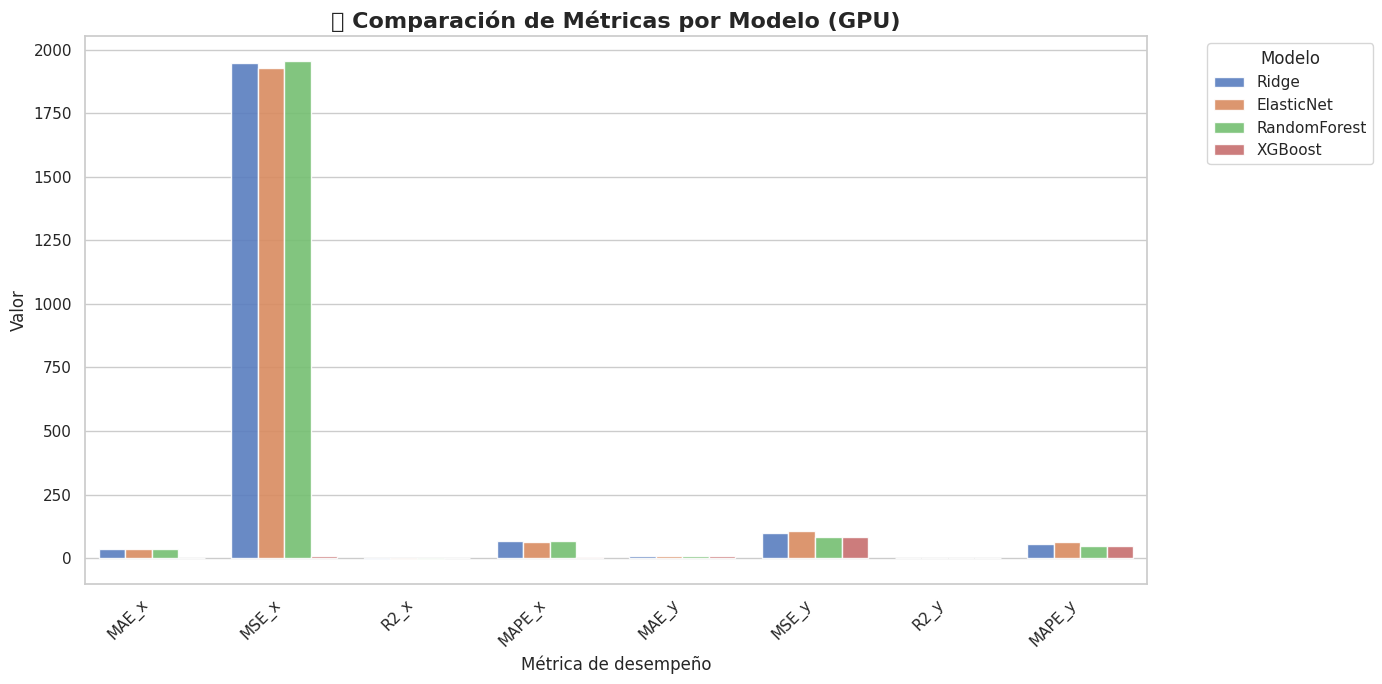

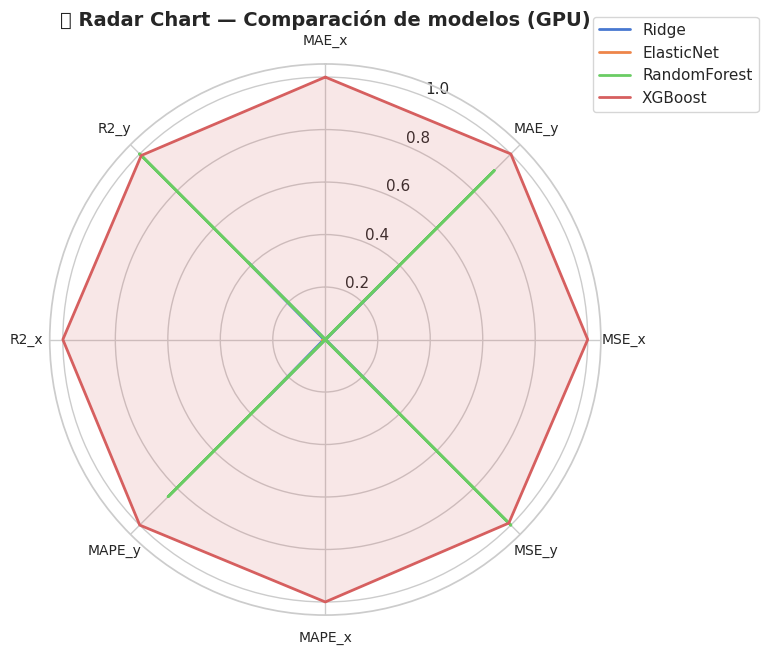

In [ ]:
# ===============================================================
# CELDA 11 — Visualización comparativa de desempeño (GPU)
# ===============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Crear carpeta results/ si no existe
os.makedirs('results', exist_ok=True)

# ---------------------------------------------------------------
# 1️⃣ Gráfico de barras comparativo de métricas
# ---------------------------------------------------------------
metrics_to_plot = ['MAE_x', 'MSE_x', 'R2_x', 'MAPE_x', 'MAE_y', 'MSE_y', 'R2_y', 'MAPE_y']

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid", palette="muted")

# Transformar el DataFrame a formato largo (long-form) para seaborn
df_melted = df_results[metrics_to_plot].reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
df_melted.rename(columns={'index': 'Model'}, inplace=True)

sns.barplot(data=df_melted, x='Metric', y='Value', hue='Model', alpha=0.9)
plt.title("📊 Comparación de Métricas por Modelo (GPU)", fontsize=16, weight='bold')
plt.xlabel("Métrica de desempeño", fontsize=12)
plt.ylabel("Valor", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('results/model_comparison_bars.pdf', format='pdf', dpi=300)
plt.show()

# ---------------------------------------------------------------
# 2️⃣ Gráfico de radar comparativo (normalizado)
# ---------------------------------------------------------------
from math import pi

radar_metrics = ['MAE_x', 'MAE_y', 'MSE_x', 'MSE_y', 'MAPE_x', 'MAPE_y', 'R2_x', 'R2_y']

# Normalizar los valores (invirtiendo errores para comparabilidad)
df_norm = df_results.copy()
for col in radar_metrics:
    if "R2" not in col:
        df_norm[col] = 1 / (df_results[col] + 1e-8)
df_norm = (df_norm - df_norm.min()) / (df_norm.max() - df_norm.min())

# Crear ángulos del radar
labels = radar_metrics
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Dibujar un gráfico por modelo
for model_name, row in df_norm.iterrows():
    values = row[labels].tolist()
    values += values[:1]
    ax.plot(angles, values, label=model_name, linewidth=2)
    ax.fill(angles, values, alpha=0.15)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=10)
ax.set_title("🕸️ Radar Chart — Comparación de modelos (GPU)", fontsize=14, weight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig('results/model_comparison_radar.pdf', format='pdf', dpi=300)
plt.show()


In [ ]:
# ===============================================================
# Tabla resumen de métricas (media ± desviación)
# ===============================================================

import pandas as pd
import numpy as np
import os

# Crear carpeta results/ si no existe
os.makedirs('results', exist_ok=True)

# ---------------------------------------------------------------
# 1️⃣ Calcular media y desviación estándar
# ---------------------------------------------------------------
# Si cada modelo tiene múltiples ejecuciones, promediamos
df_summary = df_results.agg(['mean', 'std']).T

# Redondear valores para presentación
df_summary = df_summary.round(4)

print("\n📊 Resumen de métricas (media ± desviación estándar):\n")
display(df_summary)

# ---------------------------------------------------------------
# 2️⃣ Guardar tabla en CSV y LaTeX para el informe
# ---------------------------------------------------------------
csv_path = "results/model_metrics_summary.csv"
latex_path = "results/model_metrics_summary.tex"

df_summary.to_csv(csv_path)
with open(latex_path, "w") as f:
    f.write(df_summary.to_latex(index=True, caption="Resumen de métricas por modelo (media ± desviación estándar)",
                                label="tab:model_metrics_summary", float_format="%.4f"))

print(f"\n✅ Tabla guardada correctamente en:\n• {csv_path}\n• {latex_path}")



📊 Resumen de métricas (media ± desviación estándar):



,mean,std
MAE_x,28.3898,17.8532
MSE_x,1459.2281,968.3384
R2_x,-1.2002,1.4600
MAPE_x,50.5086,30.7823
MAE_y,7.8019,0.8020
MSE_y,92.4887,12.9008
R2_y,0.4779,0.0728
MAPE_y,53.1550,7.1972
MEAN_DIST,31.2978,15.7909
STD_DIST,18.2152,8.4344



✅ Tabla guardada correctamente en:
• results/model_metrics_summary.csv
• results/model_metrics_summary.tex


In [ ]:
# ===============================================================
# INSTALAR LIBRERÍA REPORTLAB (para generación de PDF)
# ===============================================================
!pip install reportlab --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.1 MB/s eta 0:00:0000:010:01


In [ ]:
# ===============================================================
# Generación de informe visual en PDF (RAPIDS + Sklearn)
# ===============================================================

from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
import matplotlib.pyplot as plt
import os

# ---------------------------------------------------------------
# 1️⃣ Crear carpeta results/
# ---------------------------------------------------------------
os.makedirs("results", exist_ok=True)

# ---------------------------------------------------------------
# 2️⃣ Crear figura resumen de métricas
# ---------------------------------------------------------------
plt.figure(figsize=(10, 6))
df_results.mean().plot(kind="bar", color=["#2E8B57", "#4682B4", "#DAA520", "#CD5C5C"])
plt.title("Rendimiento Promedio de Modelos (Métricas Combinadas)", fontsize=14)
plt.ylabel("Score (promedio normalizado)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
metrics_plot_path = "results/model_metrics_overview.png"
plt.savefig(metrics_plot_path, dpi=300)
plt.close()

# ---------------------------------------------------------------
# 3️⃣ Crear documento PDF con ReportLab
# ---------------------------------------------------------------
pdf_path = "results/NFL_Model_Report.pdf"
doc = SimpleDocTemplate(pdf_path, pagesize=letter)
styles = getSampleStyleSheet()
elements = []

# ---------------------------------------------------------------
# 4️⃣ Agregar título y descripción general
# ---------------------------------------------------------------
elements.append(Paragraph("<b>NFL Big Data Bowl 2026 – Informe de Resultados</b>", styles["Title"]))
elements.append(Spacer(1, 12))
elements.append(Paragraph(
    "Este informe resume el proceso de entrenamiento, validación y evaluación de modelos de regresión "
    "utilizando el conjunto de datos del NFL Big Data Bowl 2026. Se aplicaron técnicas de optimización "
    "bayesiana y se evaluaron métricas clave (MAE, MSE, R², MAPE) sobre los conjuntos de validación y prueba.",
    styles["Normal"]
))
elements.append(Spacer(1, 12))

# ---------------------------------------------------------------
# 5️⃣ Insertar tabla de métricas (resumen Celda 12)
# ---------------------------------------------------------------
data = [["Métrica"] + list(df_summary.columns)] + df_summary.reset_index().values.tolist()
table = Table(data, repeatRows=1)
table.setStyle(TableStyle([
    ('BACKGROUND', (0,0), (-1,0), colors.lightblue),
    ('TEXTCOLOR', (0,0), (-1,0), colors.white),
    ('ALIGN', (0,0), (-1,-1), 'CENTER'),
    ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
    ('FONTSIZE', (0,0), (-1,0), 10),
    ('BOTTOMPADDING', (0,0), (-1,0), 10),
    ('BACKGROUND', (0,1), (-1,-1), colors.whitesmoke),
    ('GRID', (0,0), (-1,-1), 0.5, colors.grey),
]))
elements.append(Paragraph("<b>Resumen de métricas promedio ± desviación estándar</b>", styles["Heading2"]))
elements.append(table)
elements.append(Spacer(1, 12))

# ---------------------------------------------------------------
# 6️⃣ Insertar gráfico resumen de rendimiento
# ---------------------------------------------------------------
elements.append(Paragraph("<b>Visualización comparativa de desempeño</b>", styles["Heading2"]))
elements.append(Image(metrics_plot_path, width=480, height=280))
elements.append(Spacer(1, 12))

# ---------------------------------------------------------------
# 7️⃣ Agregar detalles del mejor modelo (por ejemplo, XGBoost)
# ---------------------------------------------------------------
best_xgb_params = {
    'eta': 0.0192469, 'max_depth': 7, 'subsample': 0.4624,
    'colsample_bytree': 0.9430, 'reg_lambda': 1.94e-05,
    'reg_alpha': 1.1313, 'n_estimators': 680, 'n_estimators_y': 585
}

elements.append(Paragraph("<b>Parámetros Óptimos del Mejor Modelo (XGBoost)</b>", styles["Heading2"]))
for k, v in best_xgb_params.items():
    elements.append(Paragraph(f"{k}: {v}", styles["Normal"]))

# ---------------------------------------------------------------
# 8️⃣ Construir PDF final
# ---------------------------------------------------------------
doc.build(elements)
print(f"\n✅ Informe PDF generado correctamente en: {pdf_path}")



✅ Informe PDF generado correctamente en: results/NFL_Model_Report.pdf


# Final punto 4

# Aqui inicia lo que se hizo en clase

In [ ]:
train_df = load_training_data()


LOADING TRAINING DATA
✓ Week 01: 285,714 rows | 748 plays
✓ Week 02: 288,586 rows | 777 plays
✓ Week 03: 297,757 rows | 823 plays
✓ Week 04: 272,475 rows | 710 plays
✓ Week 05: 254,779 rows | 677 plays
✓ Week 06: 270,676 rows | 715 plays
✓ Week 07: 233,597 rows | 646 plays
✓ Week 08: 281,011 rows | 765 plays
✓ Week 09: 252,796 rows | 656 plays
✓ Week 10: 260,372 rows | 673 plays
✓ Week 11: 243,413 rows | 657 plays
✓ Week 12: 294,940 rows | 755 plays
✓ Week 13: 233,755 rows | 622 plays
✓ Week 14: 279,972 rows | 738 plays
✓ Week 15: 281,820 rows | 702 plays
✓ Week 16: 316,417 rows | 822 plays
✓ Week 17: 277,582 rows | 734 plays
✓ Week 18: 254,917 rows | 686 plays

Total training data: 4,880,579 rows
 Unique plays: 14,108
Players to predict: 1,303,440


In [ ]:
train_df.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


In [ ]:
train_df.describe()

,game_id,play_id,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
count,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06
mean,2.023155e+09,2.196409e+03,4.955890e+04,1.613179e+01,6.055045e+01,2.112783e+02,6.050074e+01,2.681190e+01,3.019878e+00,2.118335e+00,1.804972e+02,1.815366e+02,1.164147e+01,6.051581e+01,2.663766e+01
std,2.011405e+05,1.246426e+03,5.210338e+03,1.113008e+01,2.305935e+01,2.217747e+01,2.348919e+01,1.000620e+01,2.227939e+00,1.415794e+00,1.007162e+02,9.800912e+01,5.331537e+00,2.529643e+01,1.543814e+01
min,2.023091e+09,5.400000e+01,3.084200e+04,1.000000e+00,1.100000e+01,1.530000e+02,4.100000e-01,6.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,-5.260000e+00,-3.910000e+00
25%,2.023101e+09,1.150000e+03,4.519800e+04,8.000000e+00,4.100000e+01,1.950000e+02,4.263000e+01,1.899000e+01,1.090000e+00,1.010000e+00,9.091000e+01,9.174000e+01,8.000000e+00,4.261000e+01,1.330000e+01
50%,2.023111e+09,2.171000e+03,5.241300e+04,1.500000e+01,6.100000e+01,2.070000e+02,6.041000e+01,2.685000e+01,2.720000e+00,1.920000e+00,1.795600e+02,1.801400e+02,1.000000e+01,6.051000e+01,2.647000e+01
75%,2.023121e+09,3.246000e+03,5.450000e+04,2.200000e+01,8.000000e+01,2.250000e+02,7.823000e+01,3.462000e+01,4.620000e+00,3.040000e+00,2.708300e+02,2.715800e+02,1.400000e+01,7.847000e+01,3.987000e+01
max,2.024011e+09,5.258000e+03,5.667300e+04,1.230000e+02,1.090000e+02,3.580000e+02,1.198600e+02,5.288000e+01,1.253000e+01,1.712000e+01,3.600000e+02,3.600000e+02,9.400000e+01,1.258500e+02,5.733000e+01


In [ ]:
import os
import matplotlib.pyplot as plt

# Asegurar que exista la carpeta de salida
os.makedirs('results', exist_ok=True)

# Graficar histogramas de todas las columnas numéricas
axes = train_df.hist(bins=50, figsize=(20, 15), alpha=0.7, grid=False, color='steelblue')

# Ajustar espaciado para evitar superposición
plt.tight_layout()

# Guardar en PDF de alta resolución
plt.savefig('results/attribute_histogram_plots.pdf', dpi=300)

# Mostrar los gráficos
plt.show()



In [ ]:
from sklearn.model_selection import train_test_split #particionar
train_set, test_set = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape,test_set.shape)#se revisa el tamaño de los sets

(3904463, 23) (976116, 23)


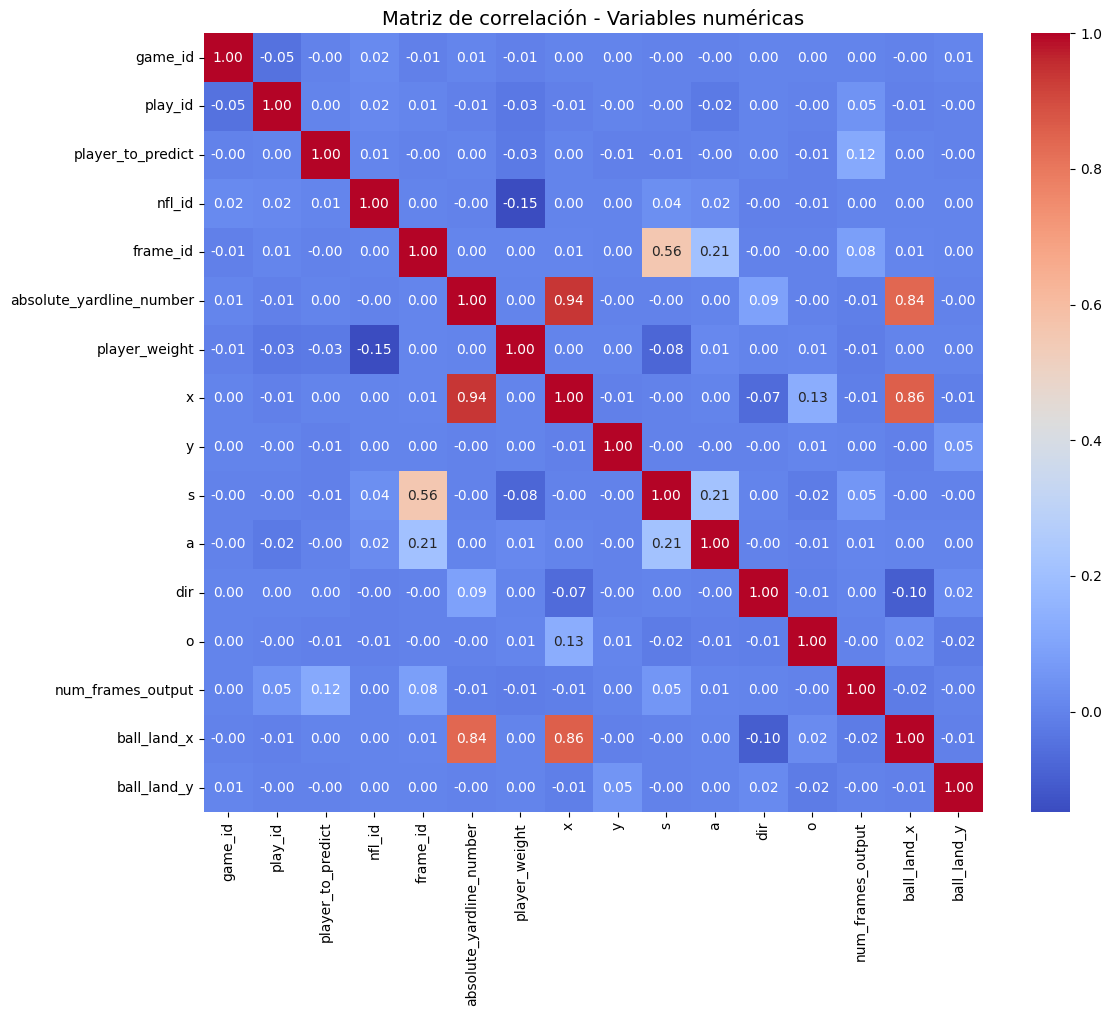

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Copiar el dataset original
train_set = train_set.copy()

# Eliminar la columna categórica si existe
train_set.drop('ocean_proximity', axis=1, inplace=True, errors='ignore')

# Calcular la matriz de correlación
corr_matrix = train_set.corr(numeric_only=True)

# Asegurar que la carpeta de resultados exista
os.makedirs('results', exist_ok=True)

# Crear figura
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Título y ajustes
plt.title('Matriz de correlación - Variables numéricas', fontsize=14)
plt.tight_layout()

# Guardar resultado
plt.savefig('results/correlation_matrix.pdf', dpi=300)
plt.show()


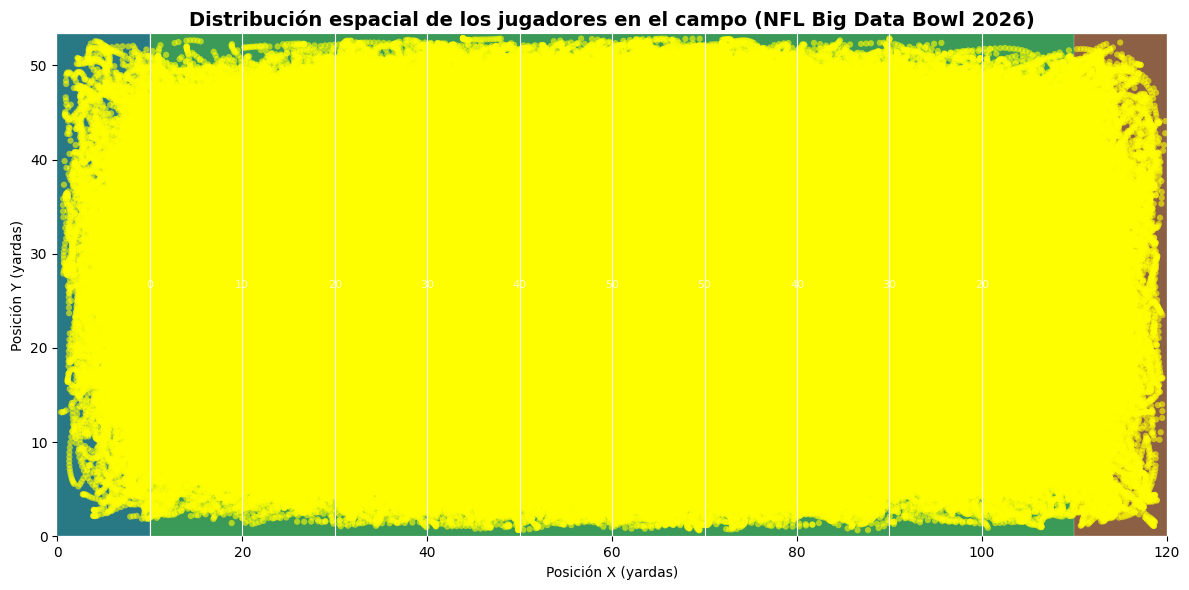

✅ Mapa generado y guardado en: results/nfl_field_player_positions.pdf


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# =====================================================
# CONFIGURACIÓN INICIAL
# =====================================================
os.makedirs('results', exist_ok=True)

# Variable de color — puedes cambiarla si tu dataset tiene otra (ej: 'acceleration', 'dir', etc.)
target_var = 'speed' if 'speed' in train_set.columns else None

# Crear figura
fig, ax = plt.subplots(figsize=(12, 6))

# =====================================================
# DIBUJAR CAMPO DE FÚTBOL AMERICANO (120 x 53.3 yardas)
# =====================================================

# Fondo del campo
field = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1, edgecolor='white', facecolor='#3B9A57')
ax.add_patch(field)

# Zonas de anotación
left_endzone = patches.Rectangle((0, 0), 10, 53.3, linewidth=0.3, edgecolor='white', facecolor='#1E63A3', alpha=0.6)
right_endzone = patches.Rectangle((110, 0), 10, 53.3, linewidth=0.3, edgecolor='white', facecolor='#C13A3A', alpha=0.6)
ax.add_patch(left_endzone)
ax.add_patch(right_endzone)

# Líneas de yarda cada 10 yardas
for x in range(10, 110, 10):
    ax.plot([x, x], [0, 53.3], color='white', linewidth=0.8)
    ax.text(x, 53.3/2, f"{x-10 if x<=60 else 120-x}", color='white', ha='center', va='center', fontsize=8, alpha=0.8)

# =====================================================
# GRAFICAR POSICIONES DE JUGADORES
# =====================================================
if target_var and target_var in train_set.columns:
    scatter = ax.scatter(
        train_set['x'], train_set['y'],
        c=train_set[target_var],
        cmap='coolwarm',
        alpha=0.6,
        s=20,
        edgecolor='none'
    )
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.02, pad=0.04)
    cbar.set_label(target_var.capitalize(), fontsize=10)
else:
    ax.scatter(train_set['x'], train_set['y'], color='yellow', alpha=0.6, s=20, edgecolor='none')

# =====================================================
# AJUSTES FINALES
# =====================================================
ax.set_xlim(0, 120)
ax.set_ylim(0, 53.3)
ax.set_xlabel("Posición X (yardas)")
ax.set_ylabel("Posición Y (yardas)")
ax.set_title("Distribución espacial de los jugadores en el campo (NFL Big Data Bowl 2026)", fontsize=14, fontweight='bold')
ax.set_facecolor("#3B9A57")

# Eliminar bordes del gráfico
for spine in ax.spines.values():
    spine.set_visible(False)

# Guardar y mostrar
plt.tight_layout()
plt.savefig("results/nfl_field_player_positions.pdf", dpi=300)
plt.show()

print("✅ Mapa generado y guardado en: results/nfl_field_player_positions.pdf")


In [ ]:
print(train_set.columns)


Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y'],
      dtype='object')


Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y'],
      dtype='object')


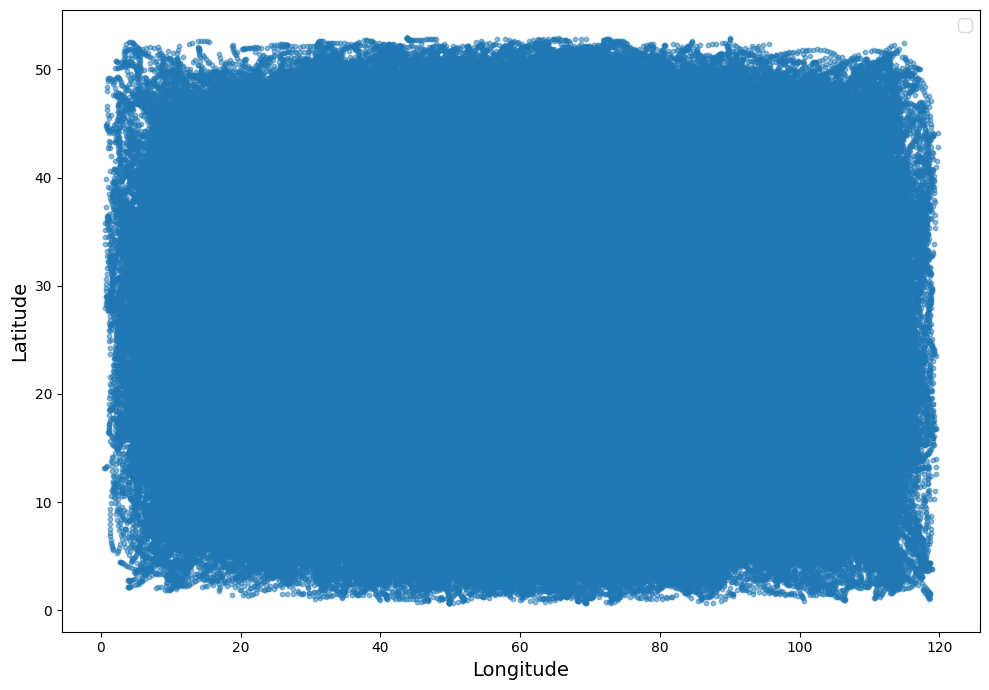

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os

# Crear carpeta para guardar resultados
os.makedirs('results', exist_ok=True)

# --- Ajusta estos nombres según tu dataset ---
x_col = 'x'          # Ejemplo: coordenada o longitud
y_col = 'y'          # Ejemplo: coordenada o latitud
color_col = 'value'  # Ejemplo: variable que quieres mostrar con colores
size_col = 'population' if 'population' in train_set.columns else None

# Verifica que existan las columnas requeridas
print(train_set.columns)

# Si tienes una imagen de fondo (opcional)
# Si no la tienes, comenta las dos líneas con 'mpimg' y 'imshow'
# california_img = mpimg.imread('Ejemplo_Drive/california.png')

# Crear gráfico
ax = train_set.plot(
    kind="scatter",
    x=x_col,
    y=y_col,
    figsize=(10, 7),
    s=(train_set[size_col] / 100) if size_col else 10,  # tamaño relativo
    c=train_set[color_col] if color_col in train_set.columns else None,
    cmap=plt.get_cmap("jet"),
    colorbar=False,
    alpha=0.5
)

# Imagen de fondo opcional
# plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

# Colorbar (solo si se usó una variable para el color)
if color_col in train_set.columns:
    prices = train_set[color_col]
    tick_values = np.linspace(prices.min(), prices.max(), 11)
    cbar = plt.colorbar(ax.collections[0])
    cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=12)
    cbar.set_label(color_col, fontsize=14)

plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('results/train_set_geo_plot.pdf', format='pdf', dpi=300)
plt.show()


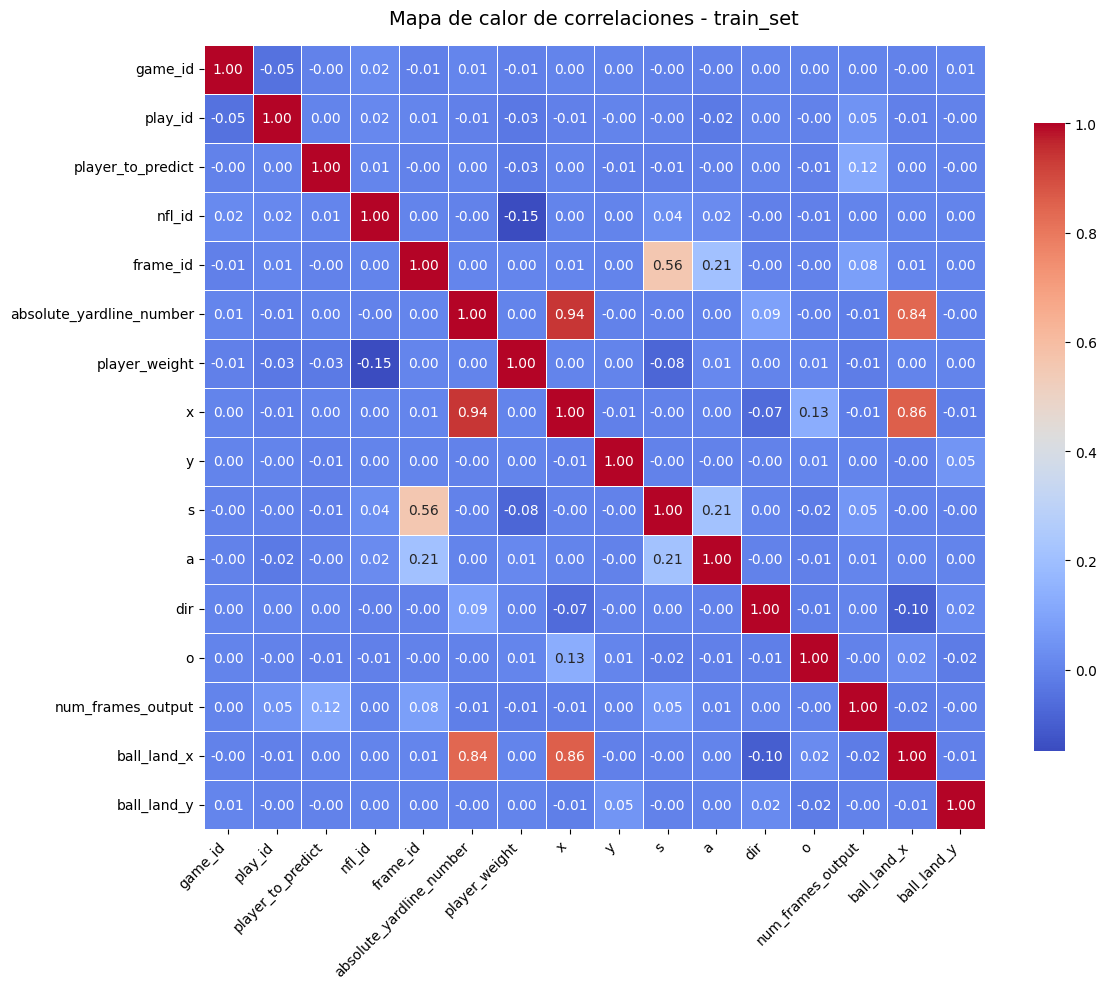

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Crear carpeta para guardar resultados
os.makedirs('results', exist_ok=True)

# --- Verificar existencia de corr_matrix ---
if 'corr_matrix' not in locals():
    corr_matrix = train_set.corr(numeric_only=True)  # calcula solo entre columnas numéricas

# --- Configurar el tamaño del gráfico ---
plt.figure(figsize=(12, 10))

# --- Crear mapa de calor con anotaciones ---
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',            # paleta de colores (puedes probar 'viridis', 'mako', 'rocket', etc.)
    annot=True,                 # mostrar valores dentro de cada celda
    fmt=".2f",                  # formato de los valores (2 decimales)
    linewidths=0.5,             # separador entre celdas
    cbar_kws={"shrink": 0.8},   # barra de color más compacta
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)

# --- Títulos y estilo ---
plt.title("Mapa de calor de correlaciones - train_set", fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

# --- Guardar el resultado en PDF ---
plt.savefig('results/corr_matrix_heatmap.pdf', format='pdf', dpi=300)
plt.show()
